# Naive Bayes Classification – Accuracy Analysis

In this notebook, we investigate the performance of **Naive Bayes** and
**Gaussian Naive Bayes** classifiers depending on the training set size.  

The goals of this experiment are:
- to compare the average accuracy of both algorithms,
- to analyze how the variance (standard deviation) of results changes with different training sizes,
- to visualize the results with accuracy curves and uncertainty bands.


## Imports and Data Preparation

We start by importing the necessary libraries (NumPy, Matplotlib, scikit-learn)
and preparing the dataset for classification.



In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

## Implementation of Naive Bayes Classifiers

In this section, we implement two variants of the Naive Bayes classifier from scratch:

### 1. Discretized Naive Bayes
- **Idea**: Continuous features are converted into discrete bins.
- **Steps**:
  - **Discretization**: Each feature is divided into a fixed number of bins. Values are mapped to bin indices.
  - **Priors**: Computed as the class frequency in the training set.
  - **Likelihoods**: For each class and each feature value (bin), we compute the relative frequency.
  - **Prediction**: For a new sample, we compute the log of the posterior probability for each class:
    \[
    \log P(C|x) = \log P(C) + \sum_{i} \log P(x_i|C)
    \]
  - The predicted class is the one with the maximum log probability.

### 2. Gaussian Naive Bayes
- **Idea**: Continuous features are modeled using a Gaussian (Normal) distribution.
- **Steps**:
  - **Priors**: Same as above.
  - **Likelihoods**: For each class and feature, we store the mean and standard deviation.
  - **Probability Density Function**: We use the Gaussian formula
    \[
    P(x_i|C) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left( -\frac{(x_i - \mu)^2}{2\sigma^2} \right)
    \]
  - **Prediction**: We compute the log probability for each class and return the class with the highest score.

### Key Notes
- Laplace smoothing is not explicitly implemented here, but very small probabilities are avoided by adding a `1e-10` floor to log computations.
- The discretized Naive Bayes depends heavily on the choice of the number of **bins**.
- Gaussian Naive Bayes directly models continuous features, which often works well for normally distributed data (like in the Iris dataset).


In [10]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

x = iris.data
y = iris.target


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

class NaiveBayes:
  def __init__(self, bins=4):
      self.priors = {}
      self.likelihoods = {}
      self.bins = bins

  def discretize_features(self, train_features: np.ndarray) -> np.ndarray:
      num_samples = train_features.shape[0]
      num_features = train_features.shape[1]
      discretized_features = np.zeros_like(train_features, dtype=int)
      for i in range(num_features):
        feature_column = train_features[:, i]
        discretized_feature = self.data_discretization(feature_column)
        discretized_features[:, i] = discretized_feature
      return discretized_features

  def calculate_priors(self, train_classes: np.ndarray) -> None:
      unique_classes, counts = np.unique(train_classes, return_counts=True)
      num_samples = len(train_classes)
      self.priors = {cls: count / num_samples for cls, count in zip(unique_classes, counts)}

  def calculate_likelihoods(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
      num_samples, num_features = train_features.shape
      unique_classes = np.unique(train_classes)
      for cls in unique_classes:
         cls_samples = train_features[train_classes == cls]
         feature_likelihoods = {}
         for feature_index in range(num_features):
            feature_column = cls_samples[:, feature_index]
            unique_values, value_counts = np.unique(feature_column, return_counts=True)
            feature_likelihoods[feature_index] = {value: count / len(feature_column) for value, count in zip(unique_values, value_counts)}
         self.likelihoods[cls] = feature_likelihoods

  def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
      discretized_feature = self.discretize_features(train_features)
      self.calculate_priors(train_classes)
      self.calculate_likelihoods(discretized_feature, train_classes)

  def data_discretization(self, data: np.ndarray) -> np.ndarray:
      min_value = np.min(data)
      max_value = np.max(data)
      width = (max_value - min_value) / self.bins

      discretized_data = np.floor((data - min_value) / width).astype(int)
      discretized_data = np.clip(discretized_data, 0, self.bins - 1)
      return discretized_data

  def predict(self, sample: np.ndarray) -> int:
      log_probabilities = {}
      for cls, prior in self.priors.items():
          log_prob = np.log(prior)
          for feature, feature_value in enumerate(sample):
              if feature in self.likelihoods[cls] and feature_value in self.likelihoods[cls][feature]:
                  log_prob += np.log(self.likelihoods[cls][feature][feature_value])
              else:
                  log_prob += np.log(1e-10)
          log_probabilities[cls] = log_prob
      return max(log_probabilities, key=log_probabilities.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def calculate_priors(self, train_classes: np.ndarray) -> None:
        unique_classes, counts = np.unique(train_classes, return_counts = True)
        num_samples = len(train_classes)
        self.priors = {cls: count / num_samples for cls, count in zip(unique_classes, counts)}

    def calculate_likelihoods(self, train_features: np.ndarray, train_classes: np.ndarray):
        self.likelihoods = {}
        num_features = train_features.shape[1]
        unique_classes = np.unique(train_classes)
        for cls in unique_classes:
          cls_samples = train_features[train_classes == cls]
          feature_likelihoods = {}
          for feature_index in range(num_features):
            feature_column = cls_samples[:, feature_index]
            mean = np.mean(feature_column)
            std = np.std(feature_column)
            feature_likelihoods[feature_index] = {mean, std}
          self.likelihoods[cls] = feature_likelihoods

    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
        self.calculate_priors(train_classes)
        self.calculate_likelihoods(train_features, train_classes)

    @staticmethod
    def normal_dist(x, mean: float, std: float) -> float:
        if std == 0:
          return 1e-10
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) ** 2) / (std ** 2))

    def predict(self, sample: np.ndarray) -> int:
        log_probabilities = {}
        for cls, prior in self.priors.items():
          log_prob = np.log(prior)
          for feature, feature_value in enumerate(sample):
            if feature in self.likelihoods[cls]:
              mean, std = self.likelihoods[cls][feature]
              log_prob += np.log(max(self.normal_dist(feature_value, mean, std), 1e-10))
          log_probabilities[cls] = log_prob
        return max(log_probabilities, key = log_probabilities.get)

## Experiment: Accuracy vs Training Size with Different Random States

In this section, we test how the classifiers perform with **different random seeds** (`random_state` values) during train/test splitting.  

Why this matters:
- The `random_state` controls how the dataset is shuffled before splitting.  
- Different splits may lead to different accuracy results, especially for small training sets.  
- By testing multiple seeds, we can see how robust and stable each classifier is.  

For each `random_state`, we:
1. Vary the **training set size** from 10% to 90%.  
2. Compute the accuracy of **Naive Bayes** and **Gaussian Naive Bayes**.  
3. Plot the results separately for each random seed.  

This allows us to check whether model performance trends are consistent across different data splits, or if they are highly dependent on the random seed.



Testing with random_state = 123


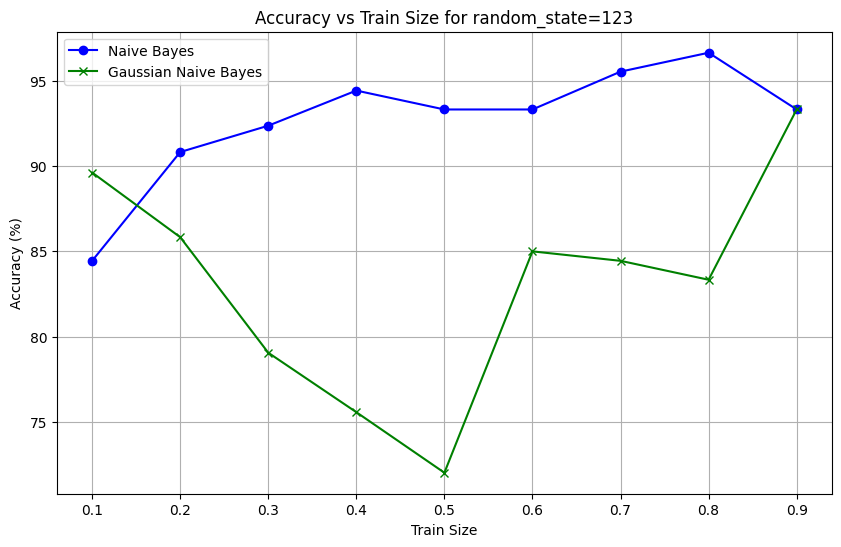


Testing with random_state = 42


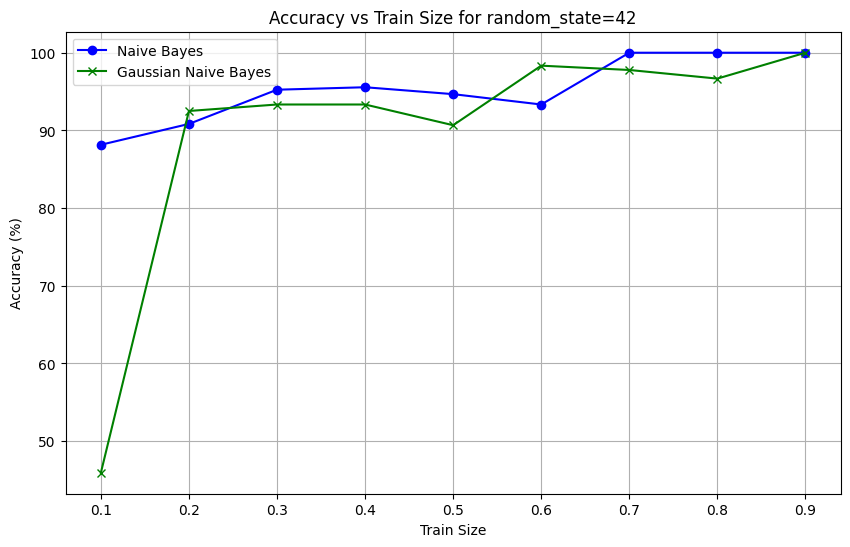


Testing with random_state = 7


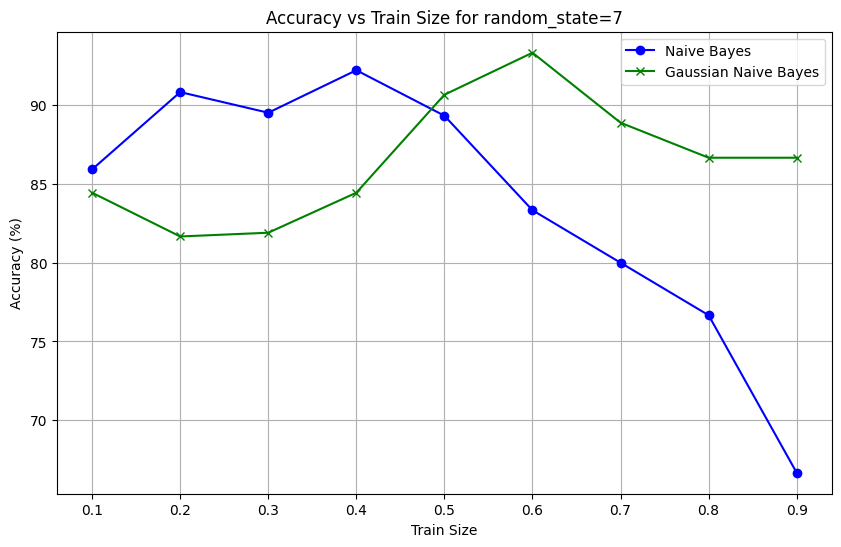


Testing with random_state = 99


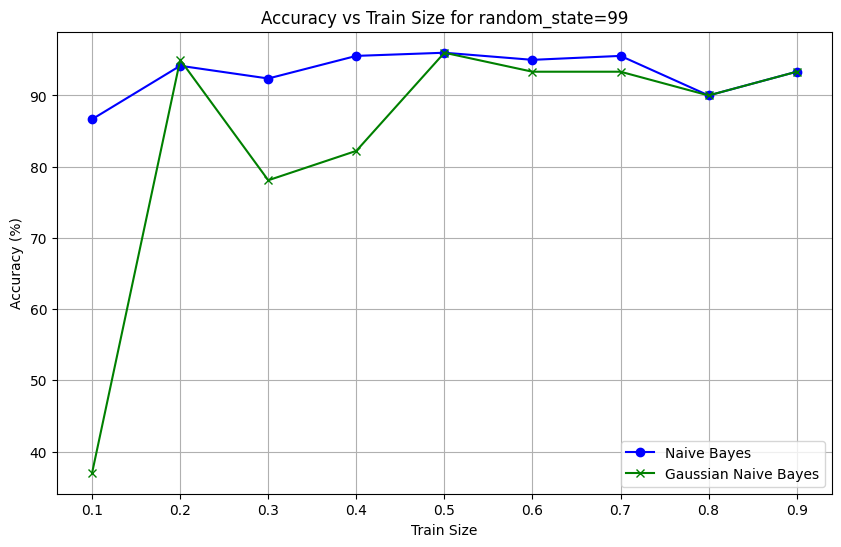

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def calculate_accuracy(x_train, x_test, y_train, y_test):
    nb_classifier = NaiveBayes()
    nb_classifier.build_classifier(x_train, y_train)
    discretized_samples = nb_classifier.discretize_features(x_test)
    nb_predictions = [nb_classifier.predict(sample) for sample in discretized_samples]
    nb_accuracy = accuracy_score(y_test, nb_predictions)

    gnb_classifier = GaussianNaiveBayes()
    gnb_classifier.build_classifier(x_train, y_train)
    gnb_predictions = [gnb_classifier.predict(sample) for sample in x_test]
    gnb_accuracy = accuracy_score(y_test, gnb_predictions)

    return nb_accuracy, gnb_accuracy

def test_accuracy_for_different_sizes_and_random_state(x, y, min_size=0.1, max_size=0.9, step=0.1, random_states=[123, 42, 7, 99]):
    for random_state in random_states:
        print(f"\nTesting with random_state = {random_state}")

        nb_accuracies = []
        gnb_accuracies = []
        train_sizes = np.arange(min_size, max_size + step, step)

        for train_size in train_sizes:
            x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
                x, y, train_size=train_size, test_size=1-train_size, random_state=random_state)

            nb_accuracy, gnb_accuracy = calculate_accuracy(x_train_split, x_test_split, y_train_split, y_test_split)

            nb_accuracies.append(nb_accuracy)
            gnb_accuracies.append(gnb_accuracy)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.array(nb_accuracies) * 100, label="Naive Bayes", color='blue', marker='o')
        plt.plot(train_sizes, np.array(gnb_accuracies) * 100, label="Gaussian Naive Bayes", color='green', marker='x')
        plt.xlabel('Train Size')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy vs Train Size for random_state={random_state}')
        plt.legend()
        plt.grid(True)
        plt.show()

test_accuracy_for_different_sizes_and_random_state(x, y, random_states=[123, 42, 7, 99])


## Experiment: Accuracy vs Number of Bins (Naive Bayes)

In this experiment, we investigate how the **number of bins** used for discretizing continuous features affects the performance of the Naive Bayes classifier.  

- The `bins` parameter determines how continuous values are split into intervals.  
- Too few bins → risk of **underfitting** (important information is lost).  
- Too many bins → risk of **overfitting** (noise is captured instead of general trends).  

Procedure:
1. Train the **Naive Bayes** classifier using different numbers of bins.  
2. Evaluate the accuracy on the test set for each configuration.  
3. Plot the results as a curve of accuracy vs. number of bins.  

This helps us identify the optimal bin size that balances bias and variance, ensuring good generalization.  


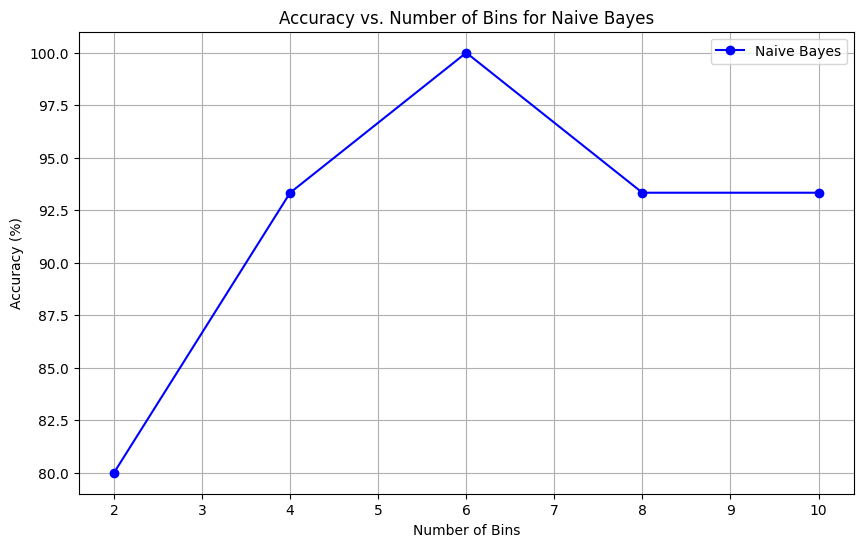

In [12]:
def test_accuracy_for_different_bins(x_train, x_test, y_train, y_test, bins_list):
    accuracies = []

    for bins in bins_list:
        nb_classifier = NaiveBayes(bins=bins)
        nb_classifier.build_classifier(x_train, y_train)

        discretized_samples = nb_classifier.discretize_features(x_test)
        nb_predictions = [nb_classifier.predict(sample) for sample in discretized_samples]

        nb_accuracy = accuracy_score(y_test, nb_predictions)
        accuracies.append(nb_accuracy)

    plt.figure(figsize=(10, 6))
    plt.plot(bins_list, np.array(accuracies) * 100, marker='o', color='blue', label='Naive Bayes')
    plt.xlabel('Number of Bins')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Number of Bins for Naive Bayes')
    plt.legend()
    plt.grid(True)
    plt.show()

bins_list = [2, 4, 6, 8, 10]
test_accuracy_for_different_bins(x_train, x_test, y_train, y_test, bins_list)

## Experiment: Impact of Training Set Size on Accuracy

We define the function `test_accuracy_for_different_sizes_random_state_none`, which:

1. For different train/test splits (from 10% to 90% of samples in the training set),
   performs multiple random splits of the dataset.
2. Computes the mean accuracy and the standard deviation for each training size.
3. Plots the results showing:
   - the average accuracy of both classifiers,
   - uncertainty bands corresponding to ±1 standard deviation.


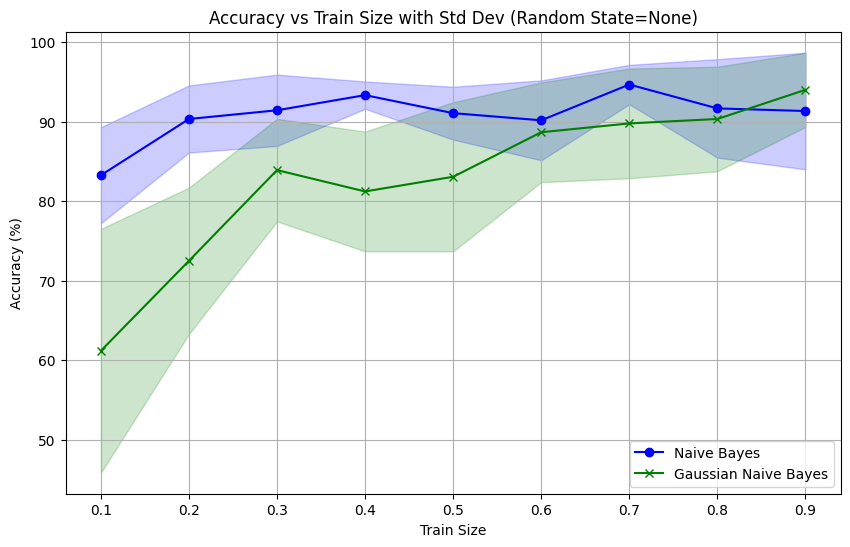

In [13]:
def test_accuracy_for_different_sizes_random_state_none(x, y, min_size=0.1, max_size=0.9, step=0.1, iterations=10):
    nb_accuracies = []
    gnb_accuracies = []
    nb_std_devs = []
    gnb_std_devs = []
    train_sizes = np.arange(min_size, max_size + step, step)

    for train_size in train_sizes:
        nb_accs = []
        gnb_accs = []
        for _ in range(iterations):
            x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
                x, y, train_size=train_size, test_size=1-train_size, random_state=None)

            nb_accuracy, gnb_accuracy = calculate_accuracy(x_train_split, x_test_split, y_train_split, y_test_split)

            nb_accs.append(nb_accuracy)
            gnb_accs.append(gnb_accuracy)

        nb_accuracies.append(np.mean(nb_accs))
        gnb_accuracies.append(np.mean(gnb_accs))

        nb_std_devs.append(np.std(nb_accs))
        gnb_std_devs.append(np.std(gnb_accs))

    plt.figure(figsize=(10, 6))

    nb_means = np.array(nb_accuracies) * 100
    gnb_means = np.array(gnb_accuracies) * 100
    nb_stds = np.array(nb_std_devs) * 100
    gnb_stds = np.array(gnb_std_devs) * 100

    plt.plot(train_sizes, nb_means, label="Naive Bayes", color='blue', marker='o')
    plt.fill_between(train_sizes, nb_means - nb_stds, nb_means + nb_stds,
                     color='blue', alpha=0.2)

    plt.plot(train_sizes, gnb_means, label="Gaussian Naive Bayes", color='green', marker='x')
    plt.fill_between(train_sizes, gnb_means - gnb_stds, gnb_means + gnb_stds,
                     color='green', alpha=0.2)

    plt.xlabel('Train Size')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Train Size with Std Dev (Random State=None)')
    plt.legend()
    plt.grid(True)
    plt.show()

test_accuracy_for_different_sizes_random_state_none(x, y)